In [445]:
from typing import Callable, List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from abc import ABC, abstractmethod
from scipy.special import gamma
from scipy.stats import special_ortho_group
from scipy.optimize import minimize_scalar
from scipy.optimize import minimize
from functools import partial
from itertools import product
from itertools import combinations


In [538]:
def parallelepiped_circumference(vertices: np.ndarray) -> float:
    """
    Compute the total circumference of the edges of a parallelepiped given its vertices.

    :param vertices: array-like, a list of numpy arrays representing the vertices of the parallelepiped
    :return: float, the total circumference of the edges
    """
    n = vertices.shape[1]
    edge_vectors = [vertices[2 ** i] - vertices[0] for i in range(n)]

    # Calculate the length of each edge vector and sum them up
    edge_lengths = [np.linalg.norm(vector) for vector in edge_vectors]
    total_circumference = 2 * n * sum(edge_lengths)

    return total_circumference

def is_parallelepiped(points, tolerance=1e-8):
    points = np.array(points)
    n = points.shape[1]

    if points.shape[0] != 2 ** n:
        return False

    # Compute edge vectors
    edge_vectors = [points[2 ** i] - points[0] for i in range(n)]

    for i in range(1, 2 ** n):
        binary_repr = format(i, f"0{n}b")
        target_point = points[0] + np.sum(
            [edge_vectors[j] * int(binary_repr[j]) for j in range(n)], axis=0
        )

        found = False
        for point in points:
            if np.linalg.norm(target_point - point) < tolerance:
                found = True
                break

        if not found:
            return False

    return True



    if len(vectors) != n:
        return False

    for point in points:
        vector_combinations = [point + vec for vec in vectors] + [point - vec for vec in vectors]
        found_counterpart = False
        for comb in vector_combinations:
            for other_point in points:
                if np.linalg.norm(comb - other_point) < tolerance:
                    found_counterpart = True
                    break
            if found_counterpart:
                break
        if not found_counterpart:
            return False

    return True

# Example usage
points = [
    [0, 0, 0],
    [1, 0, 0],
    [0, 1, 0],
    [1, 1, 0],
    [0, 0, 1],
    [1, 0, 1],
    [0, 1, 1],
    [1, 1, 1]
]

print(is_parallelepiped(points))  # Should print True


True


In [522]:

from scipy.integrate import nquad, dblquad

In [523]:
# Here we are testing multiple integrals that we shall use for computing the hypersurface area of an ellipsoid
def f(x,y,z):
    return x**2 + y**3 + z

nquad(f, [[0, 1], [1, 2], [1, 4]])

(19.750000000000004, 2.1926904736346847e-13)

In [524]:
class ConvexBody(ABC):
    '''This is an abstract class for convex bodies. '''
    def __init__(self, dim):
        self.dim = dim

    @abstractmethod
    def plot(self, filename):
        pass

In [525]:
class Ellipsoid(ConvexBody):
    def __init__(self, radii):
        self.radii = np.array(radii)
        self.dim = len(radii)
        self.coordinates = [self._coordinate(i) for i in range(self.dim)]

    def _coordinate(self, i):
        def coordinate(u, v):
            if i == 0:
                return self.radii[0] * np.cos(u) * np.sin(v)
            elif i == 1:
                return self.radii[1] * np.sin(u) * np.sin(v)
            elif i == self.dim - 1:
                return self.radii[-1] * np.cos(v)
            else:
                return self.radii[i] * np.sin(u) * np.cos(v)

        return coordinate
    

    def is_point_on_surface(self, point: List[float], tolerance: float = 1e-6) -> bool:
        """
        Check whether the given point lies on the surface of the ellipsoid.

        Parameters
        ----------
        point : list[float]
            A list of Cartesian coordinates of the point to be checked.
        tolerance : float, optional
            The tolerance to determine if the point lies on the surface of the ellipsoid.
            The default value is 1e-6.

        Returns
        -------
        bool
            True if the point lies on the surface of the ellipsoid, False otherwise.
        """
        # Compute the value of the ellipsoid equation for the given point:
        # (x/a)^2 + (y/b)^2 + (z/c)^2 - 1
        ellipsoid_value = sum(
            (point[i] / self.radii[i]) ** 2 for i in range(len(self.radii))
        ) - 1

        # Check if the ellipsoid value is within the tolerance.
        return abs(ellipsoid_value) <= tolerance


    def hypersurface_measure(self, k):
        """
        Calculate the k-dimensional hypersurface measure of the ellipsoid.

        :param k: int, dimension of the hypersurface (1 <= k <= n)
        :return: float, the k-dimensional hypersurface measure
        """
        if k == 0:
            return 1
        elif k == self.dim:
            return np.prod(self.radii) * np.pi**(self.dim / 2) / np.prod([np.math.gamma((i + 1) / 2) for i in range(1, self.dim * 2, 2)])
        elif self.dim == 2 and k == 1:
            # For a 2D ellipse, k must be 1, and we're calculating the perimeter
            # Use the Ramanujan approximation
            a, b = self.radii
            h = ((a - b)**2) / ((a + b)**2)
            return np.pi * (a + b) * (1 + (3 * h) / (10 + np.sqrt(4 - 3 * h)))
        elif self.dim == 1 and k == 1:
            # For a 1D ellipse, k must be 1, and we're calculating the length
            return 2 * self.radii[0]
        else:
            raise NotImplementedError("Hypersurface measures for k != n are only implemented for 1D and 2D ellipsoids.")






    def _surface_area_element(self, u, v):
        """
        Calculate the surface area element for the given parameter values u and v.

        :param u: float, parameter value u
        :param v: float, parameter value v
        :return: float, the surface area element
        """
        metric_tensor = np.zeros((self.dim - 1, self.dim - 1))
        for i in range(self.dim - 1):
            for j in range(self.dim - 1):
                partial_i = self.partial(self.coordinates[i], u, v)
                partial_j = self.partial(self.coordinates[j], u, v)
                metric_tensor[i, j] = np.dot(partial_i, partial_j)

        return np.sqrt(np.linalg.det(metric_tensor))

    def partial(self, coordinate, u, v, eps=1e-5):
        """
        Calculate the partial derivatives of the given coordinate function with respect to u and v.

        :param coordinate: function, the coordinate function
        :param u: float, parameter value u
        :param v: float, parameter value v
        :param eps: float, the step size for numerical differentiation (optional, default: 1e-5)
        :return: tuple, the partial derivatives with respect to u and v
        """
        du = (coordinate(u + eps, v) - coordinate(u - eps, v)) / (2 * eps)
        dv = (coordinate(u, v + eps) - coordinate(u, v - eps)) / (2 * eps)
        return du, dv

    def __repr__(self):
        """
        A string representation of the ellipsoid.

        :return: str, the string representation of the ellipsoid
        """
        return f"Ellipsoid(radii={self.radii})"

    def sample_points_on_surface(self, k):
        """
        Sample k points uniformly on the surface of the ellipsoid.

        :param k: int, the number of points to sample
        :return: numpy array, a (k, n) array of k points on the surface of the ellipsoid
        """
        # Sample points on the surface of an n-dimensional unit sphere
        points = self._sample_points_on_unit_sphere(k)

        # Scale the points by the radii of the ellipsoid
        scaled_points = points * self.radii

        return scaled_points

    def _sample_points_on_unit_sphere(self, k):
        """
        Sample k points uniformly on the surface of an n-dimensional unit sphere.

        :param k: int, the number of points to sample
        :return: numpy array, a (k, n) array of k points on the surface of the unit sphere
        """
        points = np.random.normal(size=(k, self.dim))
        points = points / np.linalg.norm(points, axis=1, keepdims=True)

        return points

    def plot(self, filename):
        if self.dim == 2:
            self._plot_2d(filename)
        elif self.dim == 3:
            self._plot_3d(filename)
        else:
            raise NotImplementedError("Plotting is only supported for 2D and 3D ellipsoids.")

    def _plot_2d(self, filename):
        theta = np.linspace(0, 2 * np.pi, 100)
        x = self.radii[0] * np.cos(theta)
        y = self.radii[1] * np.sin(theta)

        plt.plot(x, y)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.savefig(filename)
        plt.clf()

    def _plot_3d(self, filename):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        u = np.linspace(0, 2 * np.pi, 100)
        v = np.linspace(0, np.pi, 100)
        x = self.radii[0] * np.outer(np.cos(u), np.sin(v))
        y = self.radii[1] * np.outer(np.sin(u), np.sin(v))
        z = self.radii[2] * np.outer(np.ones(np.size(u)), np.cos(v))

        ax.plot_surface(x, y, z, color='b', alpha=0.6)
        #plt.savefig(filename)
        plt.clf()


In [526]:
def test_ellipse_perimeter():
    ellipse = Ellipsoid([3, 2])
    a, b = 3, 2
    h = ((a - b)**2) / ((a + b)**2)
    expected_perimeter = np.pi * (a + b) * (1 + (3 * h) / (10 + np.sqrt(4 - 3 * h)))  # Ramanujan approximation
    actual_perimeter = ellipse.hypersurface_measure(1)
    np.testing.assert_almost_equal(actual_perimeter, expected_perimeter, decimal=5)

def test_circle_area():
    circle = Ellipsoid([5, 5])
    expected_area = np.pi * 5**2
    actual_area = circle.hypersurface_measure(2)
    np.testing.assert_almost_equal(actual_area, expected_area, decimal=5)


def test_sphere_surface_area():
    sphere = Ellipsoid([3, 3, 3])
    expected_surface_area = 4 * np.pi * 3**2
    actual_surface_area = sphere.hypersurface_measure(2)
    np.testing.assert_almost_equal(actual_surface_area, expected_surface_area, decimal=5)

def test_ellipsoid_volume():
    ellipsoid = Ellipsoid([2, 3, 4])
    expected_volume = 4/3 * np.pi * 2 * 3 * 4
    actual_volume = ellipsoid.hypersurface_measure(3)
    np.testing.assert_almost_equal(actual_volume, expected_volume, decimal=5)



In [527]:
if __name__ == "__main__":
    test_ellipse_perimeter()
    test_circle_area()
    #test_ellipsoid_volume()

In [528]:
class Parallelepiped:
    def __init__(self, vectors, origin):
        """
        Initialize the parallelepiped with its n vectors and origin.

        :param vectors: array-like, a list of n numpy arrays representing the n-dimensional vectors
        :param origin: array-like, a numpy array representing the origin point
        """
        self.vectors = np.array(vectors)
        self.origin = np.array(origin)
        self.dim = len(vectors)
        
    def get_vertices(self):
        vertices = [self.origin]
        for i in range(1, 2 ** self.dim):
            binary_repr = format(i, f"0{self.dim}b")
            vertex = self.origin.copy()
            for j, bit in enumerate(binary_repr):
                if bit == '1':
                    vertex += self.vectors[j]
            vertices.append(vertex)
        return np.array(vertices)


        
    def plot(self, ellipsoid=None, filename=None):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        if ellipsoid is not None:
            ellipsoid.plot(ax)

        vertices = self.get_vertices()
        faces = [
            [vertices[0], vertices[1], vertices[5], vertices[4]],
            [vertices[2], vertices[3], vertices[7], vertices[6]],
            [vertices[0], vertices[1], vertices[3], vertices[2]],
            [vertices[4], vertices[5], vertices[7], vertices[6]],
            [vertices[0], vertices[2], vertices[6], vertices[4]],
            [vertices[1], vertices[3], vertices[7], vertices[5]]
        ]

        face_collection = Poly3DCollection(faces, linewidths=1, edgecolors='k', alpha=0.5)
        face_colors = ['red', 'blue', 'green', 'yellow', 'cyan', 'magenta']
        face_collection.set_facecolor(face_colors)
        ax.add_collection3d(face_collection)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        if ellipsoid is not None:
            max_radius = np.max(ellipsoid.radii)
            ax.set_xlim(-max_radius, max_radius)
            ax.set_ylim(-max_radius, max_radius)
            ax.set_zlim(-max_radius, max_radius)

        if filename is not None:
            plt.savefig(filename)
        else:
            plt.show()

    def hypersurface_measure(self, k):
        if k != 2:
            raise ValueError("Only 2-dimensional surface area calculation is supported")

        vector_combinations = list(combinations(self.vectors, k))

        # Calculate the sum of the absolute values of the determinants of all combinations
        hypersurface_measure = sum(
            [np.linalg.norm(np.cross(*comb)) for comb in vector_combinations]
        )

        return hypersurface_measure


    def total_edge_circumference(self):
        """
        Compute the total circumference of the edges of the parallelepiped.

        :return: float, the total circumference of the edges
        """
        # Calculate the length of each vector and sum them up
        edge_lengths = [np.linalg.norm(vector) for vector in self.vectors]
        return 2 * self.dim * sum(edge_lengths)

    def __repr__(self):
        """
        A string representation of the parallelepiped.
        """
        vectors_formatted = np.array2string(self.get_vertices(), formatter={'float_kind': lambda x: f'{x:.2f}'})
        return f"Parallelepiped(vertices={vectors_formatted}, origin={self.origin})"
    
    def is_point_on_surface(self, point, tolerance=1e-8):
        """
        Check if a point is on the surface of the parallelepiped.

        :param point: array-like, a numpy array representing the point to check
        :param tolerance: float, the tolerance for floating point comparisons

        :return: bool, True if the point is on the surface of the parallelepiped, False otherwise
        """
        vertices = self.get_vertices()
        # Check if the point is within the tolerance of any of the edges
        for i in range(len(vertices)):
            for j in range(i + 1, len(vertices)):
                edge = vertices[j] - vertices[i]
                projection = np.dot(point - vertices[i], edge) / np.dot(edge, edge)
                # Check if the projection is within the tolerance and the point is within the bounds of the edge
                if 0 <= projection <= 1 and np.linalg.norm(point - (vertices[i] + projection * edge)) <= tolerance:
                    return True
        return False
    
    def is_vertex(self, point, tolerance=1e-8):
        """
        Check if a point is a vertex of the parallelepiped.

        :param point: array-like, a numpy array representing the point to check
        :param tolerance: float, the tolerance for floating point comparisons

        :return: bool, True if the point is a vertex of the parallelepiped, False otherwise
        """
        vertices = self.get_vertices()
        for vertex in vertices:
            # Check if the distance between the point and a vertex is within the tolerance
            if np.linalg.norm(point - vertex) <= tolerance:
                return True
        return False


In [529]:
class InscribedParallelepiped(Ellipsoid):
    def __init__(self, radii):
        """
        Initialize the inscribed parallelepiped with the given ellipsoid radii.

        :param radii: array-like, a list or a numpy array of n radii for the ellipsoid
        """
        self.ellipsoid = Ellipsoid(radii)
        self.dim = len(radii)

        # Sample a random point on the ellipsoid surface
        origin = self.ellipsoid.sample_points_on_surface(1)[0]

        # Generate the remaining points on the surface
        points = self._generate_inscribed_points(origin)

        # Compute the parallelepiped vectors and create a Parallelepiped instance
        vectors = [points[i] - origin for i in range(len(radii))]
        self.parallelepiped = Parallelepiped(vectors, origin)
        
    

    def _generate_inscribed_points(self, origin):
        """
        Generate the remaining points on the surface of the ellipsoid for the inscribed parallelepiped.

        :param origin: array-like, a numpy array representing the origin point
        :return: list, a list of numpy arrays representing the remaining inscribed points
        """
        points = []

        for _ in range(self.dim):
            # Sample a point on the ellipsoid surface and compute its reflection
            point = self.ellipsoid.sample_points_on_surface(1)[0]
            reflection = 2 * origin - point

            # Add the reflected point to the list of points
            points.append(reflection)

        return points
    
    

    def hypersurface_measure(self, k):
        """
        Calculate the k-dimensional hypersurface measure of the inscribed parallelepiped.

        :param k: int, the dimension of the hypersurface measure
        :return: float, the k-dimensional hypersurface measure
        """
        return self.parallelepiped.hypersurface_measure(k)

    def total_edge_circumference(self):
        """
        Compute the total circumference of the edges of the inscribed parallelepiped.

        :return: float, the total circumference of the edges
        """
        return self.parallelepiped.total_edge_circumference()

    def __repr__(self):
        """
        A string representation of the inscribed parallelepiped.

        :return: str, the string representation of the inscribed parallelepiped
        """
        return f"InscribedParallelepiped(ellipsoid={self.ellipsoid}, parallelepiped={self.parallelepiped})"
    
    @classmethod
    def maximize_edge_circumference(cls, radii, origin, ellipsoid=None):
        def objective(points):
            points = points.reshape(-1, len(radii))
            vectors = [points[i] - origin for i in range(len(radii))]
            parallelepiped = Parallelepiped(vectors, origin)
            return -parallelepiped.total_edge_circumference()

        def constraint(points):
            points = points.reshape(-1, len(radii))
            return [np.linalg.norm(point - origin) - radius for point, radius in zip(points, radii)]

        if ellipsoid is None:
            ellipsoid = Ellipsoid(radii)

        # Use the surface points of the ellipsoid as initial points for optimization
        surface_points = ellipsoid.sample_points_on_surface(len(radii))
        initial_points = np.array(surface_points)

        # Optimize the objective function with the Nelder-Mead method
        result = minimize(
            objective,
            initial_points.flatten(),
            method="SLSQP",
            constraints={"type": "eq", "fun": constraint},
            options={"maxiter": 1000, "ftol": 1e-4},
        )

        # Create an inscribed parallelepiped with the optimized points
        optimized_points = result.x.reshape(-1, len(radii))
        vectors = [optimized_points[i] - origin for i in range(len(radii))]
        parallelepiped = Parallelepiped(vectors, origin)

        return parallelepiped

    
    @classmethod
    def maximize_surface_area(cls, radii, origin, ellipsoid=None):
        def objective(points):
            points = points.reshape(-1, len(radii))
            vectors = [points[i] - origin for i in range(len(radii))]
            parallelepiped = Parallelepiped(vectors, origin)
            return -parallelepiped.hypersurface_measure(2)

        def constraint(points):
            points = points.reshape(-1, len(radii))
            return [np.linalg.norm(point - origin) - radius for point, radius in zip(points, radii)]

        if ellipsoid is None:
            ellipsoid = Ellipsoid(radii)

        # Use the surface points of the ellipsoid as initial points for optimization
        surface_points = ellipsoid.sample_points_on_surface(len(radii))
        initial_points = np.array(surface_points)

        # Optimize the objective function with the Nelder-Mead method
        result = minimize(
            objective,
            initial_points.flatten(),
            method="SLSQP",
            constraints={"type": "eq", "fun": constraint},
            options={"maxiter": 1000, "ftol": 1e-4},
        )

        # Create an inscribed parallelepiped with the optimized points
        optimized_points = result.x.reshape(-1, len(radii))
        vectors = [optimized_points[i] - origin for i in range(len(radii))]
        parallelepiped = Parallelepiped(vectors, origin)

        return parallelepiped


In [530]:
class LpBall(ConvexBody):
    """
    A class representing an LpBall in n-dimensional space.

    Attributes:
        n (int): The dimension of the space.
        p (float): The parameter p of the Lp-norm.
        radius (float): The radius of the LpBall.
    """
    def __init__(self, n, p, radius=1):
        self.n = n
        self.p = p
        self.radius = radius

    def is_point_on_surface(self, point, tolerance=1e-8):
        """
        Check if a point is on the surface of the LpBall.

        Parameters:
            point (numpy.ndarray): A point in the n-dimensional space.
            tolerance (float, optional): A tolerance value for determining if the point is on the surface.

        Returns:
            bool: True if the point is on the surface, False otherwise.
        """
        return np.abs(np.sum(np.abs(point) ** self.p) - self.radius**self.p) <= tolerance
    
    def distance_from_surface(self, point):
        """
        Compute the distance from the point to the surface of the LpBall.

        The distance is positive if the point is inside the LpBall and negative if it is outside.

        Parameters:
            point (numpy.ndarray): A point in the n-dimensional space.

        Returns:
            float: The distance from the point to the surface of the LpBall.
        """
        lp_norm = np.power(np.sum(np.power(np.abs(point), self.p)), 1 / self.p)
        return self.radius - lp_norm
    
    def sample_points_on_surface(self):
        """
        Draw a random point uniformly on the surface of the LpBall.

        Returns:
            numpy.ndarray: A random point on the surface of the LpBall.
        """
        # Generate a random point on the unit LpBall (i.e., radius=1).
        unit_lp_ball_point = np.random.randn(self.n)
        unit_lp_ball_point /= np.power(np.sum(np.abs(unit_lp_ball_point) ** self.p), 1 / self.p)
        
        # Scale the point to the desired LpBall radius.
        return self.radius * unit_lp_ball_point
    
    def plot(self, num_points=1000):
        """
        Plot the LpBall in 2D space.

        Parameters:
            num_points (int, optional): The number of points used to plot the LpBall. Default is 1000.
        """
        if self.n != 2:
            raise NotImplementedError("Plotting is currently only supported for 2D LpBalls.")

        # Generate points on the LpBall
        angles = np.linspace(0, 2 * np.pi, num_points)
        x = self.radius * np.cos(angles)
        y = self.radius * np.sin(angles)
        points = np.column_stack((x, y))
        points_on_surface = np.power(np.abs(points), self.p - 1) * np.sign(points)
        points_on_surface /= np.power(np.sum(np.abs(points_on_surface) ** self.p, axis=1), 1 / self.p)[:, np.newaxis]

        # Plot the LpBall
        plt.figure()
        plt.plot(points_on_surface[:, 0], points_on_surface[:, 1])
        plt.gca().set_aspect('equal', adjustable='box')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(f"LpBall with p={self.p} and radius={self.radius}")
        plt.show()


In [531]:
class ParallelepipedInscribedInLpBall:
    
    def __init__(self, lp_ball, origin):
        self.lp_ball = lp_ball
        self.origin = np.array(origin)

    @staticmethod
    def _constraint(vectors_flat, lp_ball, origin):
        vectors = vectors_flat.reshape(-1, lp_ball.n)
        vertices = np.vstack([origin, origin + vectors])
        constraint_values = np.array([lp_ball.distance_from_surface(vertex) for vertex in vertices])
        return constraint_values

    @classmethod
    def maximize_edge_circumference(cls, lp_ball, origin):
        
        def objective(vectors_flat, lp_ball, origin):
            vectors = vectors_flat.reshape(-1, lp_ball.n)
            parallelepiped = Parallelepiped(vectors, origin)
            return -parallelepiped.total_edge_circumference()

        initial_vectors = np.eye(lp_ball.n)
        initial_vectors_flat = initial_vectors.flatten()
        
        result = minimize(
            objective,
            initial_vectors_flat,
            args=(lp_ball, origin),
            method="SLSQP",
            constraints={"type": "eq", "fun": cls._constraint, "args": (lp_ball, origin)},
            options={"maxiter": 1000, "ftol": 1e-8},
        )

        optimized_vectors = result.x.reshape(-1, lp_ball.n)
        return Parallelepiped(optimized_vectors, origin)
    
    def _compute_inscribed_parallelepiped(self):
        # Compute the parallelepiped vertices
        vertices = self.lp_ball.get_vertices()
        self.vertices = vertices

        # Compute the vectors of the parallelepiped
        vectors = [vertices[i] - vertices[0] for i in range(1, 2*self.n)]

        # Create a new Parallelepiped object
        self.parallelepiped = Parallelepiped(vectors, vertices[0])

    def _compute_inscribed_parallelepiped(self):
        # Compute the parallelepiped vertices
        vertices = self.lp_ball.get_vertices()
        self.vertices = vertices

        # Compute the vectors of the parallelepiped
        vectors = [vertices[i] - vertices[0] for i in range(1, 2*self.n)]

        # Create a new Parallelepiped object
        self.parallelepiped = Parallelepiped(vectors, vertices[0])

    def plot(self, filename=None):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        # Plot the LpBall
        self.lp_ball.plot(ax=ax)

        # Plot the inscribed parallelepiped
        vertices = self.parallelepiped.get_vertices()
        faces = [
            [vertices[0], vertices[1], vertices[5], vertices[4]],
            [vertices[2], vertices[3], vertices[7], vertices[6]],
            [vertices[0], vertices[1], vertices[3], vertices[2]],
            [vertices[4], vertices[5], vertices[7], vertices[6]],
            [vertices[0], vertices[2], vertices[6], vertices[4]],
            [vertices[1], vertices[3], vertices[7], vertices[5]]
        ]
        face_collection = Poly3DCollection(faces, linewidths=1, edgecolors='k', alpha=0.5)
        face_colors = ['red', 'blue', 'green', 'yellow', 'cyan', 'magenta']
        face_collection.set_facecolor(face_colors)
        ax.add_collection3d(face_collection)

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')

        if filename is not None:
            plt.savefig(filename)
        else:
            plt.show()

$\ell_p$-balls in $\mathbb R^n$.

In [544]:
n, p, radius = 4, 57, 1
lp_ball = LpBall(n, p, radius)
point_on_surface = lp_ball.sample_points_on_surface()
print(f"Initial point: {point_on_surface}")
print("Is point on surface?", lp_ball.is_point_on_surface(point_on_surface, radius))

best_parallelepiped = ParallelepipedInscribedInLpBall.maximize_edge_circumference(lp_ball, origin = point_on_surface)
print("Best inscribed parallelepiped:", best_parallelepiped)
print(f"Is point a vertex? {best_parallelepiped.is_vertex(point_on_surface)}")

print("Total edge circumference:", best_parallelepiped.total_edge_circumference())

Initial point: [0.11425735 0.4934511  0.08900486 1.        ]
Is point on surface? True
Best inscribed parallelepiped: Parallelepiped(vertices=[[0.11 0.49 0.09 1.00]
 [0.11 0.49 0.09 2.00]
 [0.11 0.49 1.09 1.00]
 [0.11 0.49 1.09 2.00]
 [0.11 1.49 0.09 1.00]
 [0.11 1.49 0.09 2.00]
 [0.11 1.49 1.09 1.00]
 [0.11 1.49 1.09 2.00]
 [1.11 0.49 0.09 1.00]
 [1.11 0.49 0.09 2.00]
 [1.11 0.49 1.09 1.00]
 [1.11 0.49 1.09 2.00]
 [1.11 1.49 0.09 1.00]
 [1.11 1.49 0.09 2.00]
 [1.11 1.49 1.09 1.00]
 [1.11 1.49 1.09 2.00]], origin=[0.11425735 0.4934511  0.08900486 1.        ])
Is point a vertex? True
Total edge circumference: 32.0


In [545]:
vertices = best_parallelepiped.get_vertices()

In [546]:
is_parallelepiped(vertices)

True

In [547]:
parallelepiped_circumference(vertices)

32.0

In [533]:
radii = [2, 1, 34]
ellipsoid = Ellipsoid(radii)

Excecute the following piece of code that uses random points on the ellipsoid surface.

Initial point: [ 1.28366808 -0.76120618 -3.15563513]
Is point on surface? True
Is point a vertex? True
Best inscribed parallelepiped for area: Parallelepiped(vertices=[[1.28 -0.76 -3.16]
 [-6.34 4.02 -35.94]
 [1.22 -1.75 -3.28]
 [-6.40 3.03 -36.07]
 [3.23 -0.83 -3.62]
 [-4.39 3.95 -36.41]
 [3.16 -1.82 -3.75]
 [-4.46 2.96 -36.53]], origin=[ 1.28366808 -0.76120618 -3.15563513])
Surface area: 104.00000459532441
Is point a vertex? True
Best inscribed parallelepiped for circumference: Parallelepiped(vertices=[[1.28 -0.76 -3.16]
 [-7.05 -1.80 29.79]
 [1.89 -0.13 -2.67]
 [-6.44 -1.17 30.28]
 [1.14 -0.76 -1.16]
 [-7.20 -1.80 31.79]
 [1.74 -0.13 -0.67]
 [-6.59 -1.17 32.27]], origin=[ 1.28366808 -0.76120618 -3.15563513])
Total edge circumference: 221.99996013399877


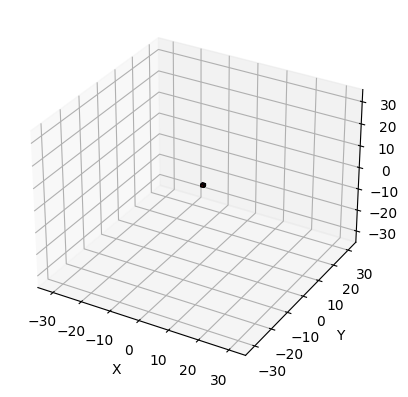

<Figure size 640x480 with 0 Axes>

In [534]:
point_on_surface = ellipsoid.sample_points_on_surface(1)[0]
print(f"Initial point: {point_on_surface}")
print(f"Is point on surface? {ellipsoid.is_point_on_surface(point_on_surface)}")

best_parallelepiped_for_area = InscribedParallelepiped.maximize_surface_area(radii, origin = point_on_surface)
print(f"Is point a vertex? {best_parallelepiped_for_area.is_vertex(point_on_surface)}")
surface_area = best_parallelepiped_for_area.hypersurface_measure(2)
print(f"Best inscribed parallelepiped for area: {best_parallelepiped_for_area}")
print(f"Surface area: {surface_area}")


best_parallelepiped_for_circumference = InscribedParallelepiped.maximize_edge_circumference(radii, origin = point_on_surface)
print(f"Is point a vertex? {best_parallelepiped_for_circumference.is_vertex(point_on_surface)}")
total_edge_circumference = best_parallelepiped_for_circumference.total_edge_circumference()
print(f"Best inscribed parallelepiped for circumference: {best_parallelepiped_for_circumference}")
print(f"Total edge circumference: {total_edge_circumference}", )


best_parallelepiped.plot(ellipsoid)

In [535]:
vertices = best_parallelepiped_for_circumference.get_vertices()

In [536]:
vertices

array([[ 1.28366808, -0.76120618, -3.15563513],
       [-7.04813877, -1.79690145, 29.79141595],
       [ 1.89107703, -0.13346012, -2.66881972],
       [-6.44072982, -1.16915539, 30.27823136],
       [ 1.13671223, -0.75982072, -1.16104629],
       [-7.19509462, -1.79551599, 31.78600478],
       [ 1.74412118, -0.13207466, -0.67423089],
       [-6.58768567, -1.16776993, 32.27282019]])

In [537]:
is_parallelepiped(vertices)

True

In [539]:
parallelepiped_circumference(vertices)

221.99996013399877

In [497]:
inscribed_parallelepiped = InscribedParallelepiped([3, 2, 1])

In [498]:
inscribed_parallelepiped.plot()

TypeError: Ellipsoid.plot() missing 1 required positional argument: 'filename'